# Join Counts

In [1]:
import geopandas as gpd
import numpy as np

from shapely.geometry import Polygon

from pysal.lib import weights
from pysal.explore import esda

import matplotlib.pyplot as plt

Generate dummy data to explore Join Counts. Use a 6x6 grid as in O'Sullivan and Unwin (**2003**)

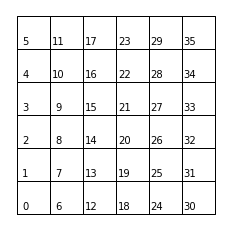

In [2]:
#hacked from https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights

# Get points in a grid
l = np.arange(6)
xs, ys = np.meshgrid(l, l)

# Set up store
polys = []

# Generate polygons (flipped x,y to number up/down rather than left/right)
for y, x in zip(xs.flatten(), ys.flatten()):
    poly = Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    polys.append(poly)

# Convert to GeoSeries
polys = gpd.GeoSeries(polys)
sgrid = gpd.GeoDataFrame({'geometry': polys, 
                        'id': [i for i in range(len(polys))]})   

#plot
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
sgrid.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
plt.gca().set_axis_off()

In [91]:
def singlePlot(col, data=sgrid):
    fig, ax = plt.subplots(1,figsize=(4,4))
    sgrid.plot(column=col, edgecolor='w', cmap='viridis_r', ax=ax)
    ax.set_title(col)
    ax.axis('off')
    plt.show()

Generate b/w for 'positive correlation' (two halves)

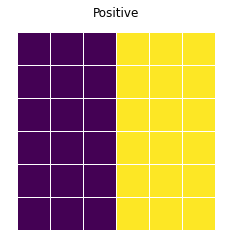

In [92]:
sgrid['Positive'] = np.where(sgrid['id']<18, 1, 0)
singlePlot('Positive')

Generate b/w for 'negative correlation' (chess board)

[1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1]


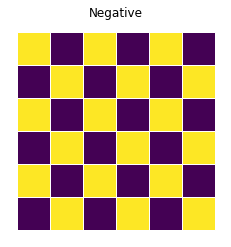

In [93]:
row1 = [1, 0, 1, 0, 1, 0]
row2 = [0, 1, 0, 1, 0, 1]

neg = row1 + row2
neg = neg * 3
print(neg)
sgrid['Negative'] = neg
singlePlot('Negative')

Generate b/w to match Figure 7.5b in O'Sullivan and Unwin (**2003**)

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


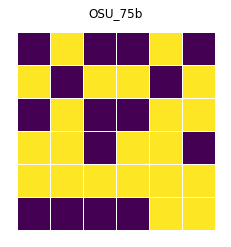

In [94]:
osuids = [0, 3, 5, 6, 10, 12, 14, 15, 17, 18, 21, 23, 28, 32, 35]
osu = [0] * 36
for i in range(0,len(osu)):
    if(i in osuids):
        osu[i] = 1
print(osu)
sgrid['OSU_75b'] = osu
singlePlot('OSU_75b')

Generate random b/w grid

[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]


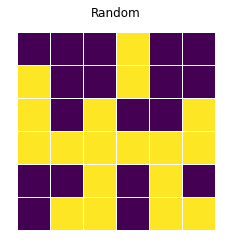

In [95]:
b = [1] * 18
w = [0] * 18
randbw = b + w
np.random.seed(2)
np.random.shuffle(randbw)
print(randbw)

sgrid['Random'] = randbw
singlePlot('Random')

Quick visualise the DataFrame we've created

In [96]:
sgrid.head()

,geometry,id,Positive,Negative,OSU_75b,Random
0,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....",0,1,1,1,1
1,"POLYGON ((0.00000 1.00000, 1.00000 1.00000, 1....",1,1,0,0,1
2,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",2,1,1,0,0
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",3,1,0,1,0
4,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1....",4,1,1,0,0


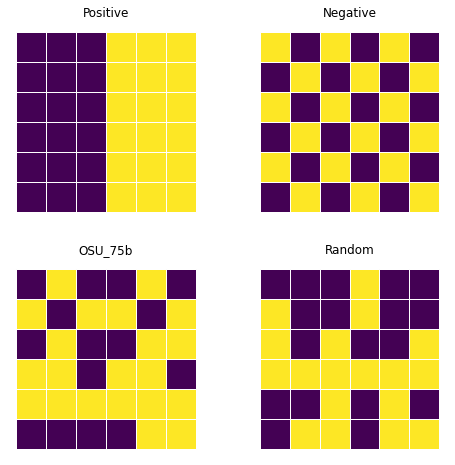

In [87]:
fig, ax = plt.subplots(2,2,figsize=(8, 8))
ax=ax.flatten()
for idx, val in enumerate(list(sgrid.loc[:,'Positive':'Random'])):
    sgrid.plot(column=val, edgecolor='w', cmap='viridis_r', ax=ax[idx])
    ax[idx].set_title(val)
    ax[idx].axis('off')
plt.show()

Create spatial weights objects for Queen's and Rooks' contiguity rules

In [45]:
QW = weights.contiguity.Queen.from_dataframe(sgrid, idVariable='id')
RW = weights.contiguity.Rook.from_dataframe(sgrid, idVariable='id')

Function to print Join Counts data for each grid

In [82]:
def printJointCounts(JCQ, JCR, gridName):
    bcount = JCQ.y.sum()
    wcount = len(JCQ.y) - bcount
    print(gridName + " Grid")
    print("\tCount Black = " + str(bcount)) 
    print("\tCount White = " + str(wcount)) 
    print("Queen's case")
    print("\tBB = " + str(JCQ.bb) + " (expected = " + str(round(JCQ.mean_bb,2)) + ")")
    print("\tWW = " + str(JCQ.ww))
    print("\tBW = " + str(JCQ.bw) + " (expected = " + str(round(JCQ.mean_bw,2)) + ")")
    print("Rook's case")
    print("\tBB = " + str(JCR.bb) + " (expected = " + str(round(JCR.mean_bb,2)) + ")")
    print("\tWW = " + str(JCR.ww))
    print("\tBW = " + str(JCR.bw) + " (expected = " + str(round(JCR.mean_bw,2)) + ")")

In [73]:
posJCQ = esda.join_counts.Join_Counts(sgrid['Positive'], QW)
posJCR = esda.join_counts.Join_Counts(sgrid['Positive'], RW)
printJointCounts(posJCQ, posJCR, 'Positive')

Positive Grid
	Count Black = 18
	Count White = 18
Queen's case
	BB = 47.0 (expected = 26.87)
	WW = 47.0 (expected = 29.7)
	BW = 16.0 (expected = 56.57)
Rook's case
	BB = 27.0 (expected = 14.66)
	WW = 27.0
	BW = 6.0 (expected = 30.75)


In [84]:
randJCQ = esda.join_counts.Join_Counts(sgrid['Random'], QW)
randJCR = esda.join_counts.Join_Counts(sgrid['Random'], RW)
printJointCounts(randJCQ, randJCR, 'Random')

Random Grid
	Count Black = 18
	Count White = 18
Queen's case
	BB = 29.0 (expected = 26.84)
	WW = 21.0
	BW = 60.0 (expected = 56.46)
Rook's case
	BB = 15.0 (expected = 14.6)
	WW = 12.0
	BW = 33.0 (expected = 30.81)


In [83]:
osuJCQ = esda.join_counts.Join_Counts(sgrid['OSU_75b'], QW)
osuJCR = esda.join_counts.Join_Counts(sgrid['OSU_75b'], RW)
printJointCounts(osuJCQ, osuJCR, 'OSU_75b')

OSU_75b Grid
	Count Black = 15
	Count White = 21
Queen's case
	BB = 14.0 (expected = 18.24)
	WW = 40.0
	BW = 56.0 (expected = 55.03)
Rook's case
	BB = 6.0 (expected = 10.13)
	WW = 19.0
	BW = 35.0 (expected = 29.83)


BW expectations are irrespective of number of B or W, and depedent only on total number of locations and contiguity rule. But BB and WW counts will be dependent on the number of B and W locations. 

Expected values for BB are much lower in `OSU_75b` than for the other grids because there are fewer black locations. But what about WW? That would expect to higher... but we can't get expected WW as an attribute - why not?

Can we calculate WW expected (e.g. as difference of expected BB and expected BW?) 

In [64]:
negJCQ = esda.join_counts.Join_Counts(sgrid['Negative'], QW)
negJCR = esda.join_counts.Join_Counts(sgrid['Negative'], RW)
printJointCounts(negJCQ, negJCR, 'Negative')

Negative Grid
	Count Black = 18
	Count White = 18
Queen's case
	BB = 25.0 (expected = 26.67)
	WW = 25.0
	BW = 60.0 (expected = 56.56)
Rook's case
	BB = 0.0 (expected = 14.73)
	WW = 0.0
	BW = 60.0 (expected = 30.62)


In [ ]:
posJCR.p_sim_bw

In [68]:
posJCR.p_sim_bb

0.001

Hypotheses for [these p-values](https://pysal.org/esda/generated/esda.Join_Counts.html#esda.Join_Counts):
- Null: complete spatial randomness
- Alternative: the observed bw or bb is greater than under randomness

In [ ]:
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
posQW.plot(sgrid, indexed_on='id', edge_kws=dict(color='r', linestyle=':'), ax =ax)
sgrid.plot(facecolor='w', edgecolor='k', ax=ax)
[ax.text(x, y, t, 
          verticalalignment='center',
          horizontalalignment='center') for x, y, t in zip(
         [p.centroid.x-.25 for p in polys],
         [p.centroid.y-.25 for p in polys],
         [i for i in sgrid['id']])]
plt.gca().set_axis_off()